/home/nilspersson/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


silhouette_score: 0.2781884468580009
davies_bouldin_score: 1.364206530781066


<ipython-input-9-3c79bd7b4c96>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis')


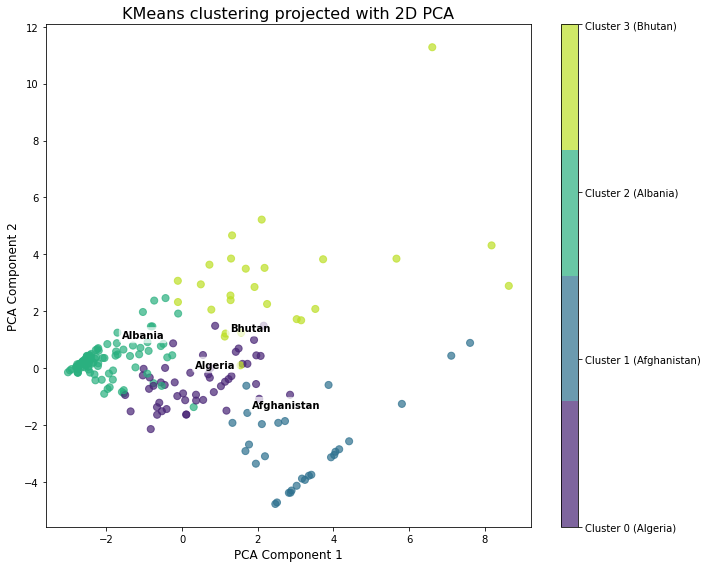

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def evaluate_clusters(metric, data, labels):
    """ Evaluates the clustering results
    
    ---------------
    Note that noise points have to be discarded, can be done via e.g. for model
    model.labels_
    
    mask = model.labels_ != -1
    data = clustering_data[mask]
    labels = model.labels_[mask]
    ---------------
    
    Params:
    metric: 
        a function for measuring cluster quality. E.g. davies_bouldin_score
        
    data: 
        dataframe or numpy array of data
        
    labels: 
        assigned labels by clustering algorightm """
    if len(np.unique(labels)) > 1:
        score = metric(data, labels)
        print(f'{metric.__name__}: {score}')
        return score
    else:
        print('Score cannot be calculated, only one cluster found.')
        
def plot_clusters_2d(model, clustering_data, full_data, noise=False):
    """ Plots the clustering in 2D PCA with improved colormap """
    full_data['Cluster'] = model.labels_
    
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(clustering_data)
    
    representative_countries = full_data.groupby('Cluster')['Location'].first()
    
    unique_clusters = np.unique(model.labels_)
    num_clusters = len(unique_clusters) - (1 if noise else 0)
    
    viridis = plt.cm.get_cmap('viridis')
    cluster_colors = viridis(np.linspace(0.1, 0.9, num_clusters))
    
    if noise:
        colors = np.vstack(([0.5, 0.5, 0.5, 1], cluster_colors))
        discrete_cmap = ListedColormap(colors)
        cluster_colors = np.where(model.labels_ == -1, 0, model.labels_ + 1)
    else:
        discrete_cmap = ListedColormap(cluster_colors)
        cluster_colors = model.labels_
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1],
                          c=cluster_colors, cmap=discrete_cmap, s=50,
                          alpha=0.7)
    
    for cluster, country in representative_countries.items():
        if cluster != -1 or not noise:
            idx = full_data[full_data['Location'] == country].index[0]
            x, y = pca_components[idx, 0], pca_components[idx, 1]
            plt.annotate(country, (x, y),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=10, weight='bold',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
            )
    
    plt.title(f'{type(model).__name__} clustering projected with 2D PCA', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    
    colorbar = plt.colorbar(scatter, aspect=30)
    if noise:
        colorbar.set_ticks(np.arange(len(unique_clusters)))
        colorbar.set_ticklabels(['Noise' if cluster == -1 else f'Cluster {cluster} ({country})' for cluster, country in representative_countries.items()])
    else:
        colorbar.set_ticks(np.arange(num_clusters))
        colorbar.set_ticklabels([f'Cluster {cluster} ({country})' for cluster, country in representative_countries.items()])

    
    plt.tight_layout()
    plt.show()

# Function to process and pivot each dataframe
def process_and_pivot(df, prefix):
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna("Not Available", inplace=True)
    
    df_filtered = df[['Location', 'Period', 'Value']]
    df_pivoted = df_filtered.pivot(index='Location', columns='Period', values='Value')
    df_pivoted = df_pivoted.rename(columns=lambda x: f"{prefix}_{x}")
    
    return df_pivoted.reset_index()

# Load the datasets
advertisingBan = pd.read_csv('../data/advertising_ban_internet.csv')
#affordability = pd.read_csv('../data/affordability.csv')
gdp2000Cigs = pd.read_csv('../data/gdp_for_2000_cigs.csv')
healthWarningPhoto = pd.read_csv('../data/health_warning_photo.csv')
requiredHealthWarnings = pd.read_csv('../data/required_health_warning.csv')

# Process and pivot each dataframe
advertisingBan_pivoted = process_and_pivot(advertisingBan, 'advertisingBan')
#affordability_pivoted = process_and_pivot(affordability, 'affordability')
gdp2000Cigs_pivoted = process_and_pivot(gdp2000Cigs, 'gdp2000Cigs')
healthWarningPhoto_pivoted = process_and_pivot(healthWarningPhoto, 'healthWarningPhoto')
requiredHealthWarnings_pivoted = process_and_pivot(requiredHealthWarnings, 'requiredHealthWarnings')

# Merge the pivoted dataframes on 'Location'
#combined_df = advertisingBan_pivoted.merge(affordability_pivoted, on='Location', how='outer')
combined_df = advertisingBan_pivoted.merge(gdp2000Cigs_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(healthWarningPhoto_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(requiredHealthWarnings_pivoted, on='Location', how='outer')

# Drop 'Location' for clustering
data_for_clustering = combined_df.drop(columns=['Location'])

# Preprocessing pipeline: imputing, encoding, and scaling
numeric_features = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_for_clustering.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Prepare the final data for clustering
clustering_data = preprocessor.fit_transform(data_for_clustering)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clustering_data)

mask = kmeans.labels_ != -1
data = clustering_data[mask]
labels = kmeans.labels_[mask]

evaluate_clusters(silhouette_score, data, labels)
evaluate_clusters(davies_bouldin_score, data, labels)

plot_clusters_2d(kmeans, clustering_data, combined_df)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Cluster  1
Afghanistan
Andorra
Barbados
Bosnia and Herzegovina
Botswana
Eswatini
Guinea-Bissau
Haiti
Lesotho
Liberia
Malawi
Mauritania
Palau
Rwanda
Saint Lucia
Sao Tome and Principe
Sierra Leone


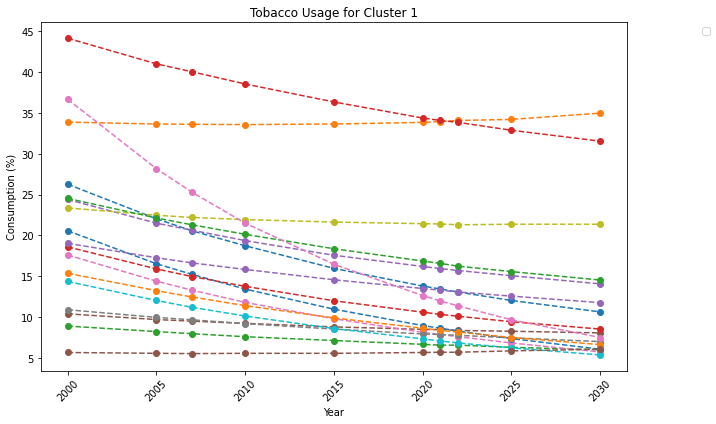

Cluster  2
Albania
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Brazil
Bulgaria
Cabo Verde
Cambodia
Canada
Chile
Colombia
Cook Islands
Costa Rica
Croatia
Cyprus
Czechia
Denmark
Ecuador
Egypt
El Salvador
Estonia
Finland
France
Germany
Ghana
Greece
Hungary
Iceland
India
Iran (Islamic Republic of)
Italy
Jordan
Kazakhstan
Kenya
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Latvia
Lithuania
Luxembourg
Malaysia
Maldives
Malta
Mauritius
Mongolia
Montenegro
Myanmar
Namibia
Netherlands (Kingdom of the)
New Zealand
Norway
Oman
Panama
Peru
Philippines
Poland
Portugal
Qatar
Republic of Korea
Romania
Russian Federation
Samoa
Saudi Arabia
Senegal
Serbia
Seychelles
Singapore
Slovakia
Slovenia
South Africa
Spain
Sweden
Thailand
Turkmenistan
Türkiye
United Arab Emirates
United Kingdom of Great Britain and Northern Ireland
Uruguay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Viet Nam
Yemen


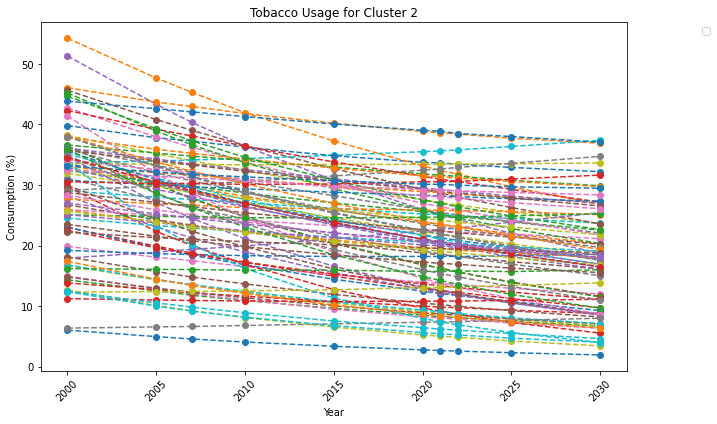

Cluster  0
Algeria
Bahamas
Belize
Benin
Bolivia (Plurinational State of)
Brunei Darussalam
Cameroon
Chad
China
Comoros
Congo
Cote d'Ivoire
Cuba
Democratic People's Republic of Korea
Dominican Republic
Fiji
Georgia
Guatemala
Guyana
Honduras
Indonesia
Iraq
Ireland
Israel
Jamaica
Japan
Lebanon
Marshall Islands
Mexico
Morocco
Nigeria
Pakistan
Paraguay
Republic of Moldova
Switzerland
Timor-Leste
Tunisia
Uganda
Ukraine
United States of America
Uzbekistan
Zambia
Zimbabwe


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


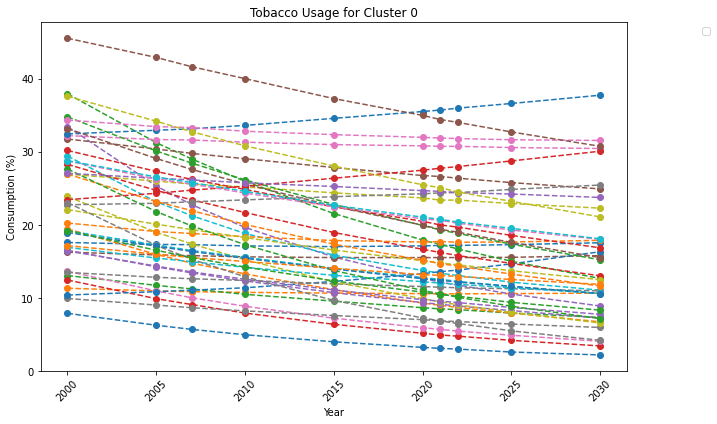

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Cluster  3
Bhutan
Burkina Faso
Burundi
Democratic Republic of the Congo
Ethiopia
Gambia
Kiribati
Madagascar
Mali
Nauru
Nepal
Niger
Papua New Guinea
Solomon Islands
Sri Lanka
Togo
Tonga
Tuvalu
United Republic of Tanzania


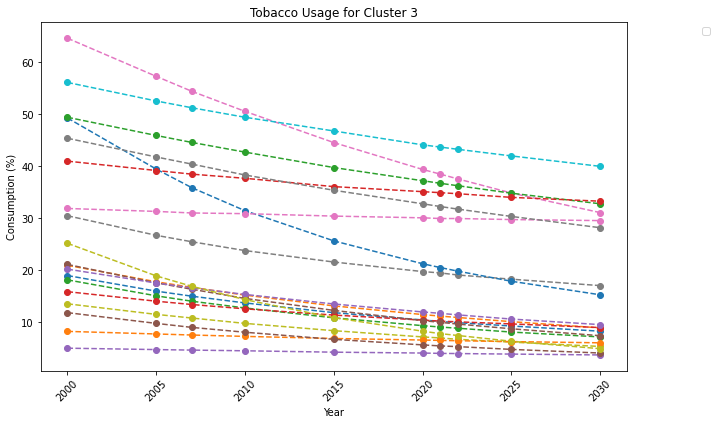

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract the first part of the cig consumption, is for example "24 [20-40]" in the csv
def extract_first_value(value):
    if isinstance(value, str):
        return value.split()[0]  
    return value  

df_cleaned = pd.read_csv("../data/age_stand.csv")
df_cleaned = df_cleaned[df_cleaned['Dim1'] == 'Both sexes']
df_cleaned['FactValueNumericLow'] = df_cleaned['Value'].apply(extract_first_value)
df_cleaned['FactValueNumericLow'] = pd.to_numeric(df_cleaned['FactValueNumericLow'], errors='coerce')


df_grouped = df_cleaned.groupby(['Location', 'Period'], as_index=False).agg({'FactValueNumericLow': 'mean'})
df_merged = pd.merge(df_grouped, combined_df[['Location', 'Cluster']], on='Location')

# 4 prints, one for each cluster
clusters = df_merged['Cluster'].unique()

for cluster in clusters:
    cluster_data = df_merged[df_merged['Cluster'] == cluster]
    
    plt.figure(figsize=(10, 6))
    print("Cluster ", cluster)
    for country in cluster_data['Location'].unique():
        print(country)
        country_data = cluster_data[cluster_data['Location'] == country]
        # Use markers ('o') to plot actual data points, with dashed lines to indicate the trend
        plt.plot(country_data['Period'], country_data['FactValueNumericLow'], marker='o', linestyle='--')
    
    plt.title(f'Tobacco Usage for Cluster {cluster}')
    plt.xlabel('Year')
    plt.ylabel('Consumption (%)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Representative country for each cluster:
Cluster 1: Afghanistan
Cluster 2: Albania
Cluster 0: Algeria
Cluster 3: Bhutan


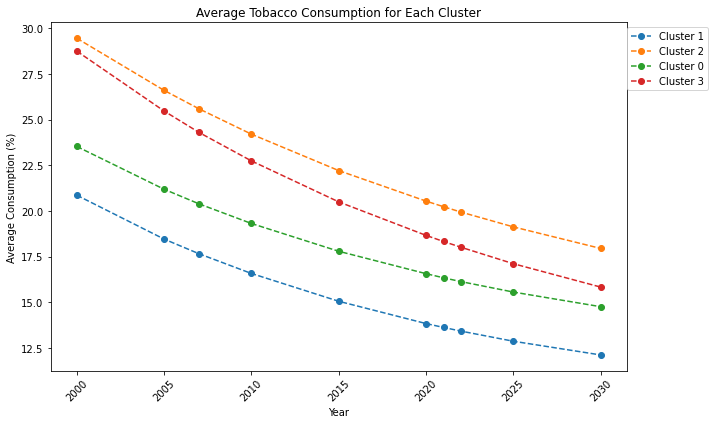

In [12]:
plt.figure(figsize=(10, 6))

for cluster in clusters:
    cluster_data = df_merged[df_merged['Cluster'] == cluster]
    cluster_avg = cluster_data.groupby('Period')['FactValueNumericLow'].mean().reset_index()
    plt.plot(cluster_avg['Period'], cluster_avg['FactValueNumericLow'], marker='o', linestyle='--', label=f'Cluster {cluster}')

plt.title('Average Tobacco Consumption for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Average Consumption (%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()